In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk 

In [29]:
#read file

df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [ ]:
df = df.head(500)
print(df.shape)

<function matplotlib.pyplot.show(close=None, block=None)>

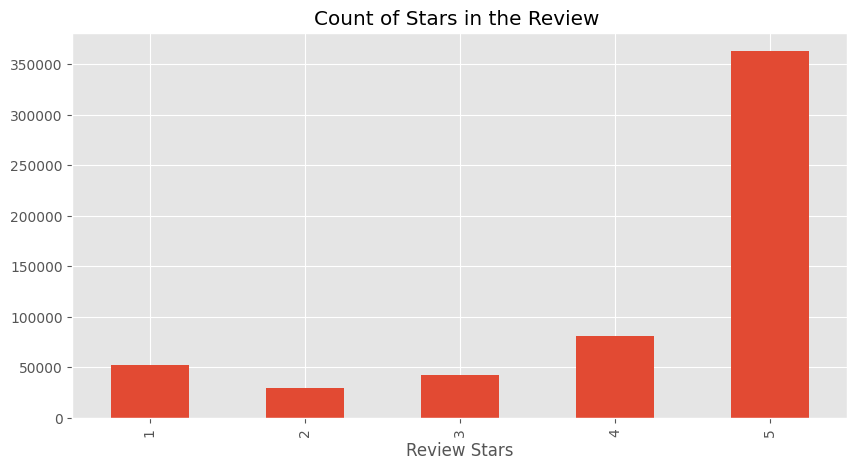

In [31]:
ax = df['Score'].value_counts().sort_index()\
    .plot(kind='bar', title='Count of Stars in the Review ',
                                             figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show

NLTK

In [32]:
#Basic NLTK
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens[:10]

In [76]:
#postag isused for classing grammatical categories
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [77]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
print(entities)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


Vader Model

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am Happy')
#Scales from 0 to 1

In [ ]:
#Hugging Face

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [33]:
# VADER results on example
print(example)
sia.polarity_scores(example)


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [37]:
encoded_text = tokenizer(example, return_tensors ='pt')

In [39]:
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores

array([ 3.14363  , -0.7106689, -2.6558967], dtype=float32)

In [41]:
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2]
}
print(scores_dict)

{'roberta_neg': 3.14363, 'roberta_neu': -0.7106689, 'roberta_pos': -2.6558967}


In [47]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors ='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu':scores[1],
    'roberta_pos':scores[2]
}
    return(scores_dict)

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
        both = {**vader_result, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [63]:
vader_result

{'neg': 0.049, 'neu': 0.854, 'pos': 0.097, 'compound': 0.2732}

In [49]:
roberta_result

{'roberta_neg': -1.9043187,
 'roberta_neu': -0.2569722,
 'roberta_pos': 2.6776965}

In [62]:

both = {**vader_result, **roberta_result}
both

{'neg': 0.049,
 'neu': 0.854,
 'pos': 0.097,
 'compound': 0.2732,
 'roberta_neg': 1.5604484,
 'roberta_neu': -0.31475592,
 'roberta_pos': -1.3197274}

In [67]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,-1.904319,-0.256972,2.677696,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.839022,0.721198,-1.740137,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,-2.881925,0.531589,2.746887,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,-3.099824,0.571630,2.880065,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,-2.485039,-0.644132,3.919230,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2460,0.037,0.735,0.228,0.9576,-2.014619,-0.568215,3.235301,B002JX7GVM,A3C5Z05IKSSFB9,"M. Magpoc ""maliasuperstar""",1,1,5,1277078400,THE BEST drink on earth!!!!!!!,This is the best drink out there! I've always...
2443,2461,0.088,0.712,0.200,0.9701,-2.188510,-0.115102,2.720867,B002JX7GVM,A1BOIDHY9SUL7T,Anakasha,1,1,4,1275868800,Not a sports drink,I started drinking coconut water when it was s...
2444,2462,0.092,0.788,0.120,0.2103,0.111163,-0.034536,0.030320,B002JX7GVM,A1HRECPV2Q79BG,718tech,1,1,5,1267056000,Amazing (even if it is trendy),I admit that I fully expected to dislike this ...
2445,2463,0.054,0.794,0.153,0.9197,-1.987156,0.173133,2.077352,B002JX7GVM,A2E2PA6UNK1E05,Labarum,1,1,5,1267056000,Good Taste but Not for Everyone,I decided to try this although I am not a big ...


Compare Scores between Models

In [59]:
results_df.columns


Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

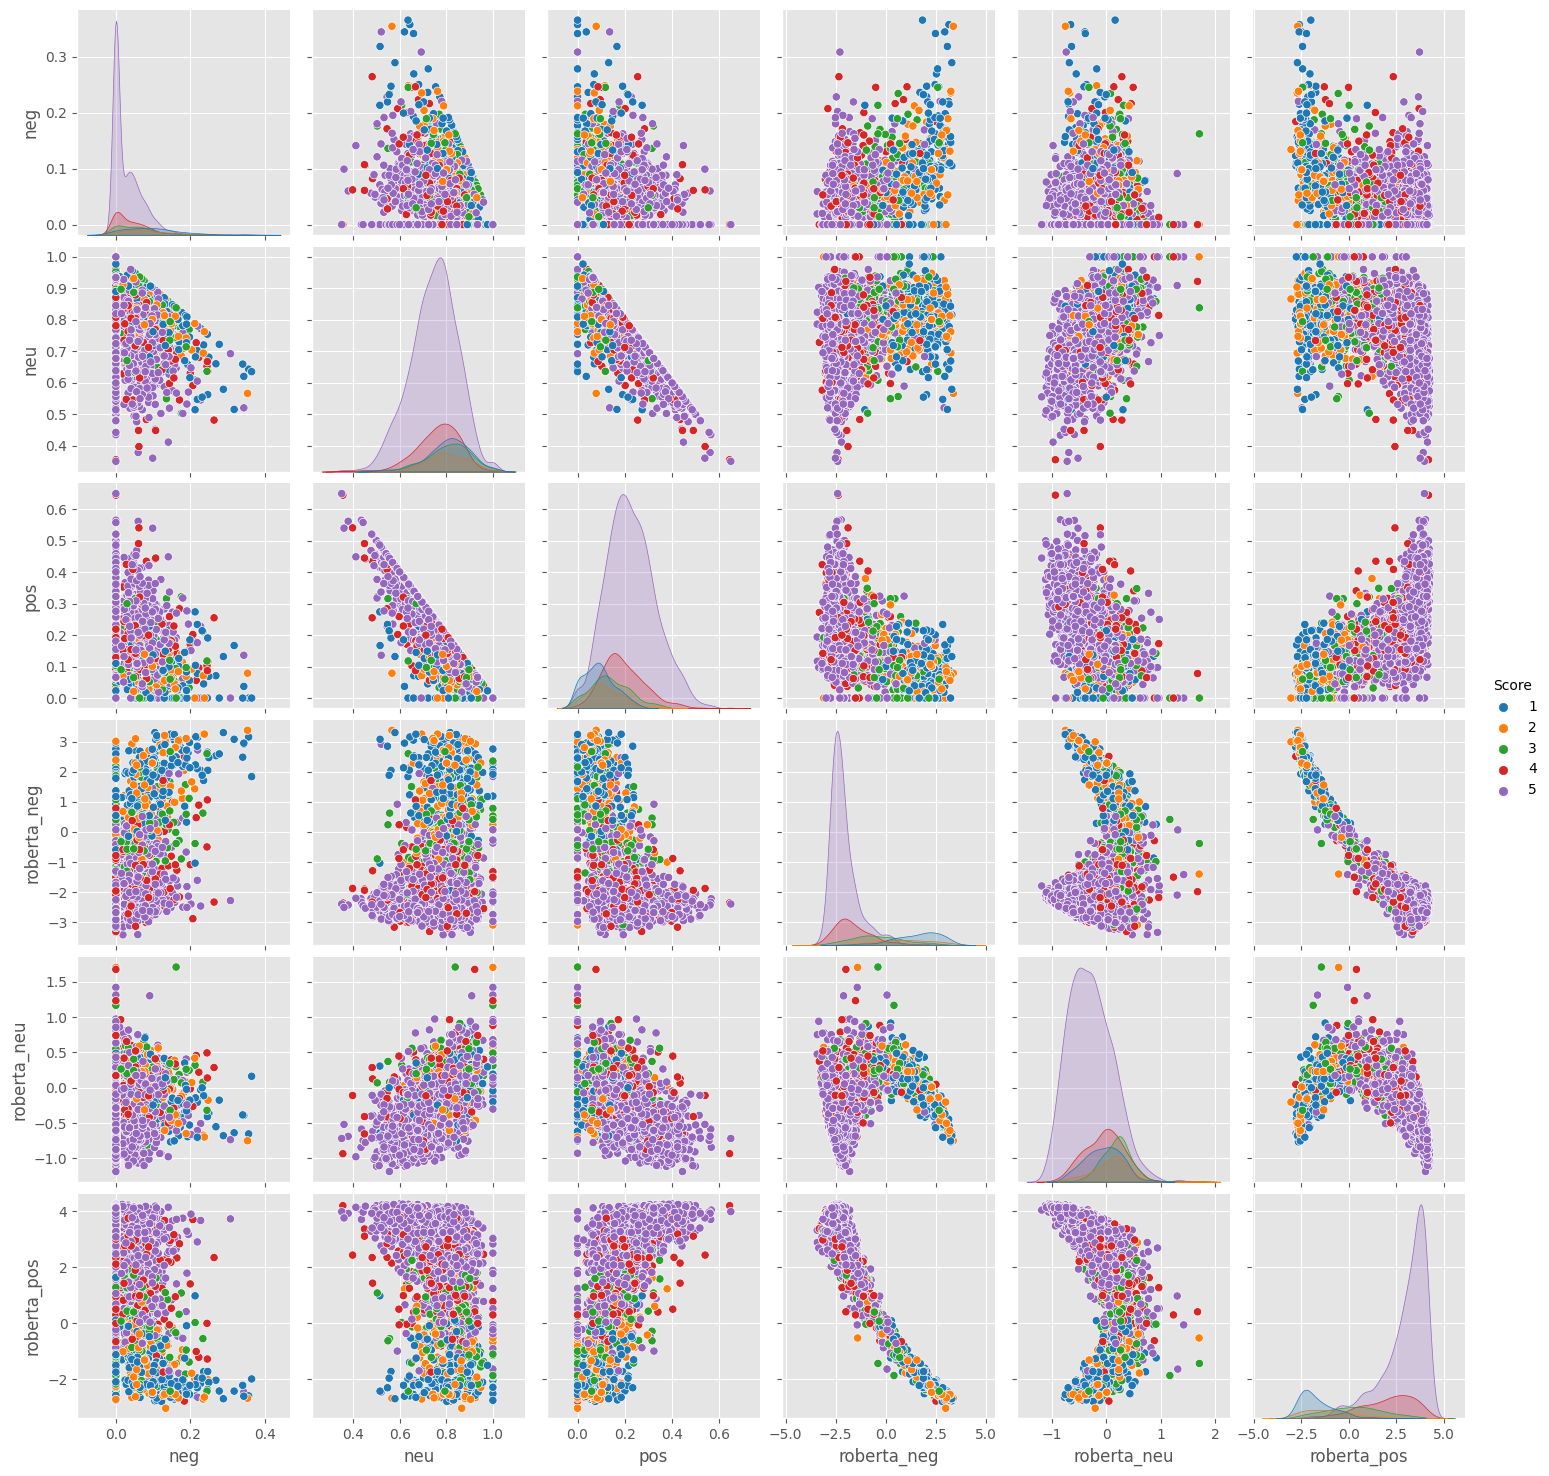

In [66]:
sns.pairplot(data = results_df,
            vars = ['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Score', palette = 'tab10')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

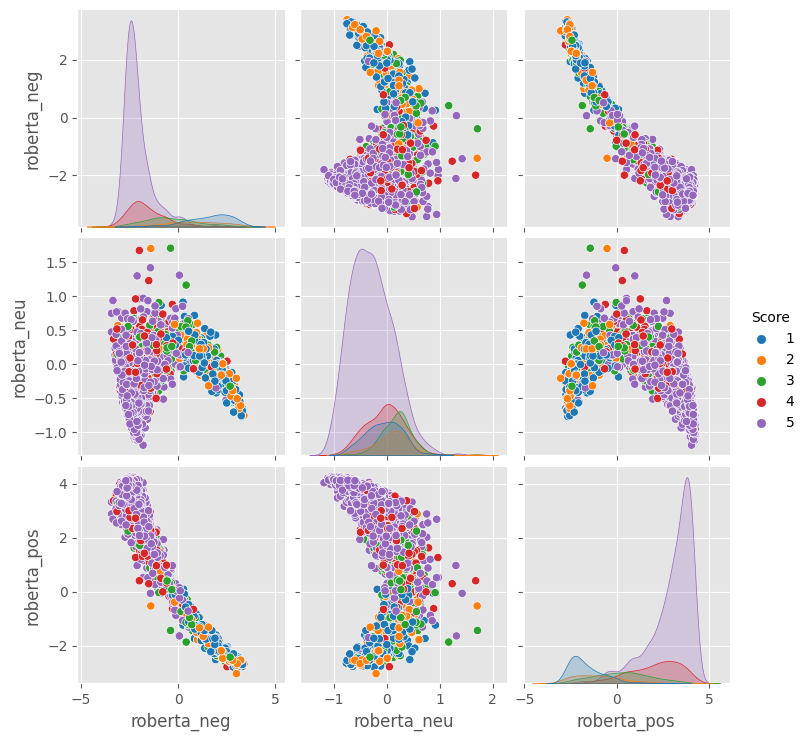

In [69]:
sns.pairplot(data = results_df,
            vars = ['roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Score', palette = 'tab10')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

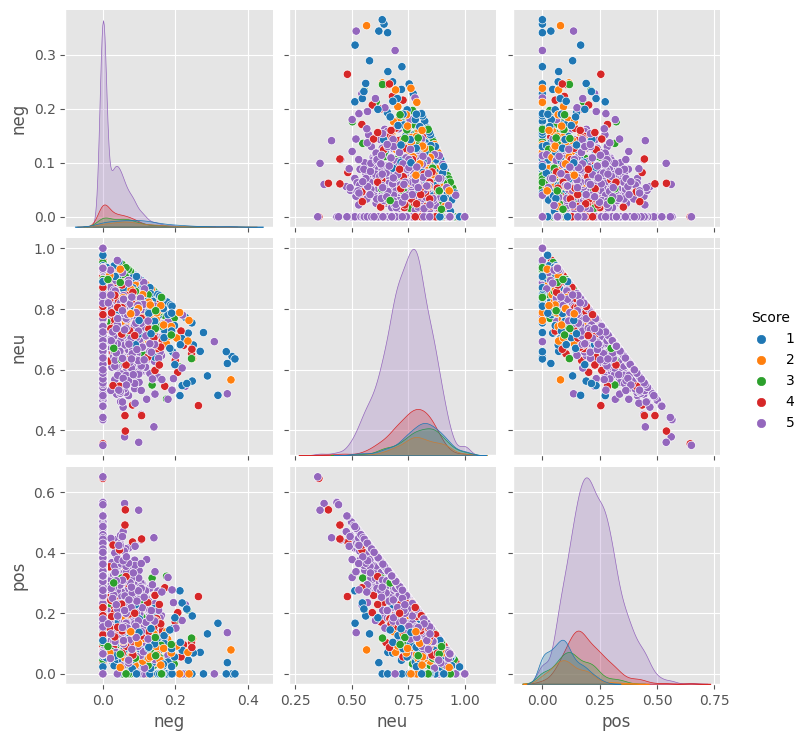

In [70]:
sns.pairplot(data = results_df,
            vars = ['neg', 'neu', 'pos',],
            hue = 'Score', palette = 'tab10')
plt.show()

In [71]:
#Positive statement with negative score
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I got two Teas and one type of iced coffe and the rest were HOLIDAY COFFEES and APPLE CIDER!  Spicy Eggnog? Gingerbread? Bait and swtich.  The only redeeming factor - Amazon was great and issued me a refund.'

In [74]:
results_df.query('Score == 1') \
    .sort_values('pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [72]:
#Negative statement with the positive value
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [75]:
results_df.query('Score == 5') \
    .sort_values('neg', ascending=False)['Text'].values[0]


'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('booo')